In [1]:
from roboflow import Roboflow


### Download dataset playing card terrabet

In [2]:


rf = Roboflow(api_key="VauuErBlrbh97X3TcXoB")
project = rf.workspace("sparkminds").project("terrabet")
version = project.version(2)
dataset = version.download("yolov8")
                

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.76, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Terrabet-2 in yolov8:: 100%|██████████| 457/457 [00:00<00:00, 935.92it/s]


### New dataset with more feature arguments data

In [80]:

from roboflow import Roboflow
rf = Roboflow(api_key="VauuErBlrbh97X3TcXoB")
project = rf.workspace("sparkminds").project("terrabet")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.76, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Terrabet-3 in yolov8:: 100%|██████████| 923/923 [00:00<00:00, 1418.24it/s]


In [3]:
import os
import random
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm.notebook import tqdm
from termcolor import colored

import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

In [55]:
# Path of dataset
base_dir = './datasets'
# base_dir = '/kaggle/input/playing-cards-object-detection-dataset'

# Path of yaml file
yaml_path = os.path.join(base_dir, 'data.yaml')

# Path of Train directory
train_dir = os.path.join(base_dir, 'train')
train_images = os.path.join(train_dir, 'images')

# Path of Validation directory
valid_dir = os.path.join(base_dir, 'valid')
valid_images = os.path.join(valid_dir, 'images')

# Path of Test directory
test_dir = os.path.join(base_dir, 'test')
test_images = os.path.join(test_dir, 'images')

In [56]:
# All the classes from yaml file
class_names = ['10c', '10d', '10h', '10s', '2c', '2d', '2h', '2s', '3c', '3d', '3h', '3s', '4c', '4d', '4h', '4s', '5c', '5d', '5h', '5s', '6c', '6d', '6h', '6s', '7c', '7d', '7h', '7s', '8c', '8d', '8h', '8s', '9c', '9d', '9h', '9s', 'Ac', 'Ad', 'Ah', 'As', 'Jc', 'Jd', 'Jh', 'Js', 'Kc', 'Kd', 'Kh', 'Ks', 'Qc', 'Qd', 'Qh', 'Qs']
print(colored(f'Number of Classes : {len(class_names)}', 'green', attrs=['bold']))

Number of Classes : 52


In [57]:
print(colored(f'Number of Train Images : {len(os.listdir(train_images))}', 'blue', attrs=['bold']))
print(colored(f'Number of Validation Images : {len(os.listdir(valid_images))}', 'blue', attrs=['bold']))
print(colored(f'Number of Test Images : {len(os.listdir(test_images))}', 'blue', attrs=['bold']))

Number of Train Images : 166
Number of Validation Images : 38
Number of Test Images : 19


In [58]:
# Define a set to store unique sizes
size = set()

# Loop over train images to check image sizes
for img_name in os.listdir(train_images) :
    img_path = os.path.join(train_images, img_name)
    img = cv2.imread(img_path)
    h, w, c = img.shape
    size.add((h, w, c))

if len(size) == 1 :
    print(colored(f'All of images have size of {(w, h, c)}', 'green', attrs=['bold']))
else :
    print(colored(f'There are {len(size)} different image sizes !', 'red', attrs=['bold']))

All of images have size of (640, 640, 3)


In [59]:
img_size = (h, w)

In [60]:
translate_cards = {
    's' : 'Spades',
    'c' : 'Clubs',
    'h' : 'Hearts',
    'd' : 'Diamonds',
    'A' : 'Ace',
    'K' : 'King',
    'Q' : 'Queen',
    'J' : 'Jack'
}


In [61]:
def label_translator(labels) :
    ''' Translate chars to labels '''
    translated_label = ''

    for card in labels :

        if card[0] in ['A', 'K', 'Q', 'J'] :
            c0 = translate_cards[card[0]]
        else :
            if len(card) == 2 :
                c0 = card[0]
            elif len(card) == 3 :
                c0 = card[:2]

        card = c0 + '-' + translate_cards[card[-1]]

        translated_label += card + '\n'
        
    translated_label = translated_label[:-1]
        
    return translated_label

In [62]:
def Draw_Bounding_Boxes(img_name) :
    ''' Show image / Draw boxes / Write class label '''
    img_path = os.path.join(train_images, img_name)
    img_path

    yaml_name = img_name[:-4] + '.txt'
    yaml_path = os.path.join(os.path.join(train_dir, 'labels'), yaml_name)

    title = []

    font = cv2.FONT_HERSHEY_SIMPLEX

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    f1 = open(yaml_path, "r")
    f2 = open(yaml_path, "r")

    for i in range(len(f1.readlines())) :
        text = f2.readline()

        yaml = text.split()

        class_name = class_names[int(yaml[0])]
        if class_name not in title :
            title.append(class_name)


        x_center = int(float(yaml[1]) * 416)
        y_center = int(float(yaml[2]) * 416)
        w = int(float(yaml[3]) * 416)
        h = int(float(yaml[4]) * 416)

        x1 = x_center - int(w/2)
        y1 = y_center - int(h/2)

        x2 = x_center + int(w/2)
        y2 = y_center + int(h/2)

        # Draw rectangles and text on image
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2, cv2.LINE_AA)
        cv2.rectangle(img, (x1+5, y1-35), (x1+65, y1-5), (255, 255, 255), -1, cv2.LINE_AA)
        cv2.putText(img, class_name, (x1+10, y1-10), font, 1, (0, 0, 255), 2, cv2.LINE_AA)

    title = label_translator(title)
    plt.title(title, fontsize=10, fontweight='bold')
    plt.axis('off')
    plt.imshow(img)

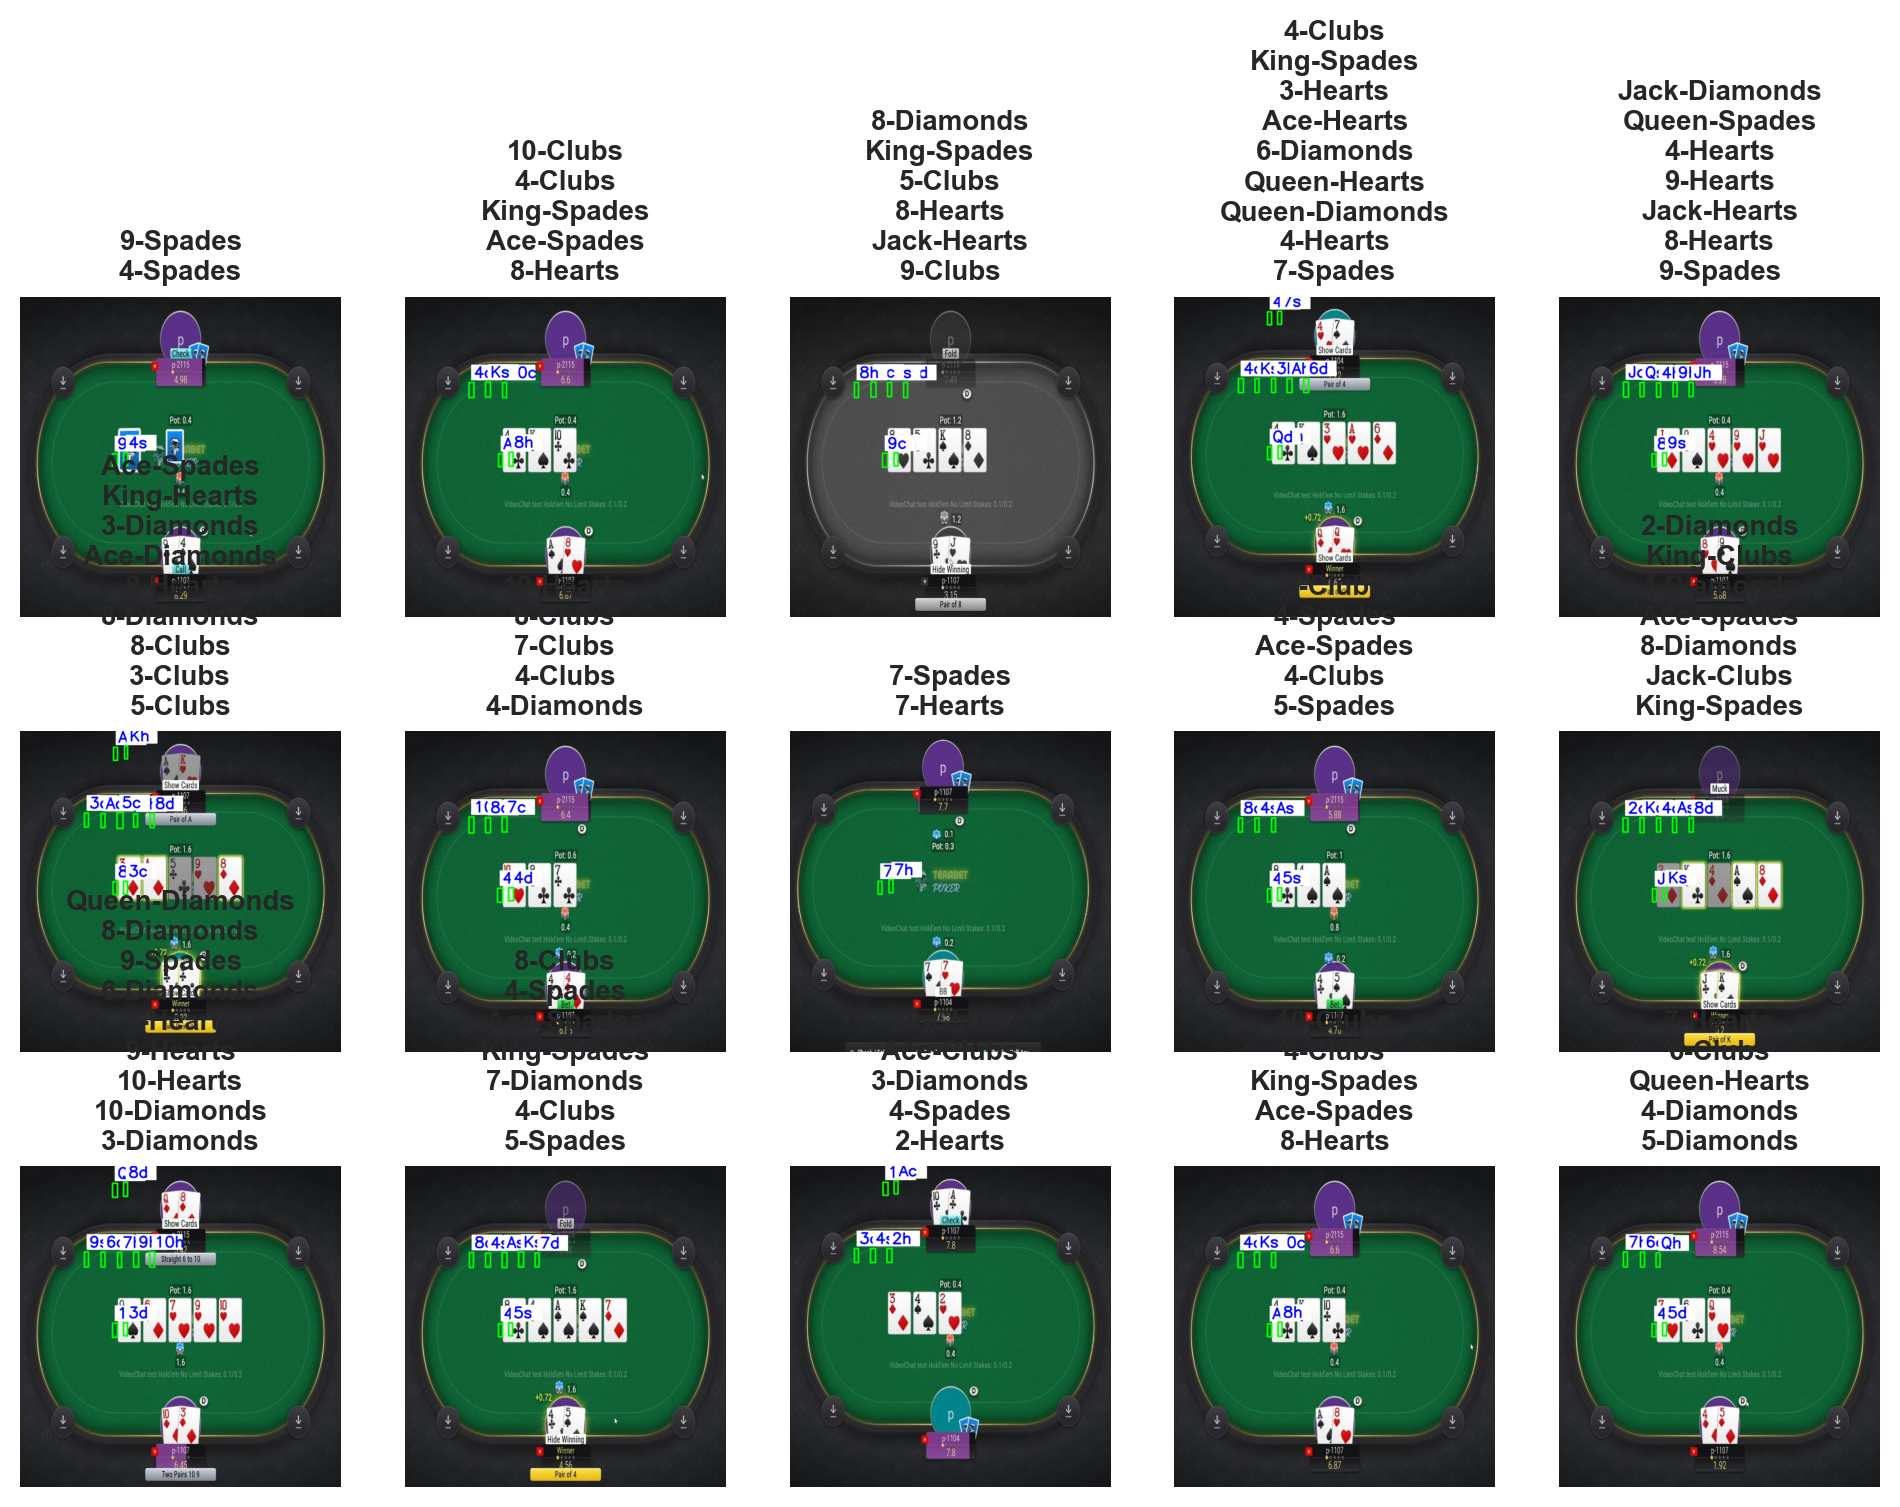

In [63]:
images = os.listdir(train_images)
num_samples = 15

random_images = random.choices(images, k=num_samples)

plt.figure(figsize=(12, 8), dpi=200)
for i in range(15) :
    plt.subplot(3, 5, i+1)
    Draw_Bounding_Boxes(random_images[i])
plt.show()


In [64]:
# Load a row model and load trained weights to it
model = YOLO('yolov8n.yaml').load('yolov8n.pt')


# Train the model
result = model.train(data=yaml_path, epochs=150, imgsz=img_size[0])

Transferred 355/355 items from pretrained weights
New https://pypi.org/project/ultralytics/8.2.77 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.76  Python-3.11.9 torch-2.1.2+cpu CPU (Intel Core(TM) i5-10400 2.90GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=./datasets\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None,

100%|██████████| 755k/755k [00:00<00:00, 949kB/s] 


Overriding model.yaml nc=80 with nc=52

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning C:\Users\Admin\Desktop\DuckCode\Python\DetectCardTerrabet\datasets\train\labels... 166 images, 0 backgrounds, 0 corrupt: 100%|██████████| 166/166 [00:00<00:00, 579.73it/s]

train: New cache created: C:\Users\Admin\Desktop\DuckCode\Python\DetectCardTerrabet\datasets\train\labels.cache



val: Scanning C:\Users\Admin\Desktop\DuckCode\Python\DetectCardTerrabet\datasets\valid\labels... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<00:00, 309.19it/s]

val: New cache created: C:\Users\Admin\Desktop\DuckCode\Python\DetectCardTerrabet\datasets\valid\labels.cache


Plotting labels to runs\detect\train6\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000179, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train6
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.657       5.97      1.084         38        640: 100%|██████████| 11/11 [01:37<00:00,  8.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.39s/it]

                   all         38        189          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.158      5.591     0.9114         33        640: 100%|██████████| 11/11 [01:16<00:00,  6.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.58s/it]

                   all         38        189          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G     0.9955      5.361     0.8475         37        640: 100%|██████████| 11/11 [01:16<00:00,  6.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.58s/it]

                   all         38        189          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G     0.9636      5.173     0.8228         36        640: 100%|██████████| 11/11 [01:19<00:00,  7.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.78s/it]

                   all         38        189          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G     0.9306       4.89     0.8284         37        640: 100%|██████████| 11/11 [01:16<00:00,  6.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.56s/it]

                   all         38        189    0.00192    0.00321    0.00398    0.00199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G     0.9566      4.722     0.8253         32        640: 100%|██████████| 11/11 [01:20<00:00,  7.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.95s/it]

                   all         38        189    0.00517     0.0561     0.0131    0.00994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G     0.9472      4.566     0.8296         43        640: 100%|██████████| 11/11 [01:20<00:00,  7.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.53s/it]

                   all         38        189      0.017      0.154     0.0276     0.0207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.9264      4.441     0.8232         31        640: 100%|██████████| 11/11 [01:23<00:00,  7.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.90s/it]

                   all         38        189      0.017      0.335     0.0332     0.0257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.8862      4.358     0.8133         33        640: 100%|██████████| 11/11 [01:24<00:00,  7.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.77s/it]

                   all         38        189     0.0144      0.437     0.0378     0.0293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.8836      4.294      0.816         33        640: 100%|██████████| 11/11 [01:21<00:00,  7.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.57s/it]

                   all         38        189     0.0263       0.61     0.0483     0.0363



10 epochs completed in 0.251 hours.
Optimizer stripped from runs\detect\train6\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train6\weights\best.pt, 6.3MB

Validating runs\detect\train6\weights\best.pt...
Ultralytics YOLOv8.2.76  Python-3.11.9 torch-2.1.2+cpu CPU (Intel Core(TM) i5-10400 2.90GHz)
YOLOv8n summary (fused): 168 layers, 3,015,788 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.95s/it]


                   all         38        189     0.0264       0.61     0.0485     0.0365
                   10c          6          6     0.0298      0.833     0.0459     0.0359
                   10d          3          3     0.0168          1     0.0247     0.0187
                   10h          1          1          0          0          0          0
                   10s          4          4     0.0165          1     0.0934     0.0773
                    2c          6          6     0.0336      0.667     0.0396     0.0322
                    2d          3          3     0.0124      0.667     0.0224     0.0161
                    2h          5          5     0.0286          1      0.037     0.0307
                    2s          4          4     0.0187        0.5     0.0156     0.0125
                    3c          3          3     0.0247      0.667      0.226      0.187
                    3d          6          6     0.0316          1     0.0418     0.0346
                    3

In [65]:
# Location of stored result
result_path = result.save_dir

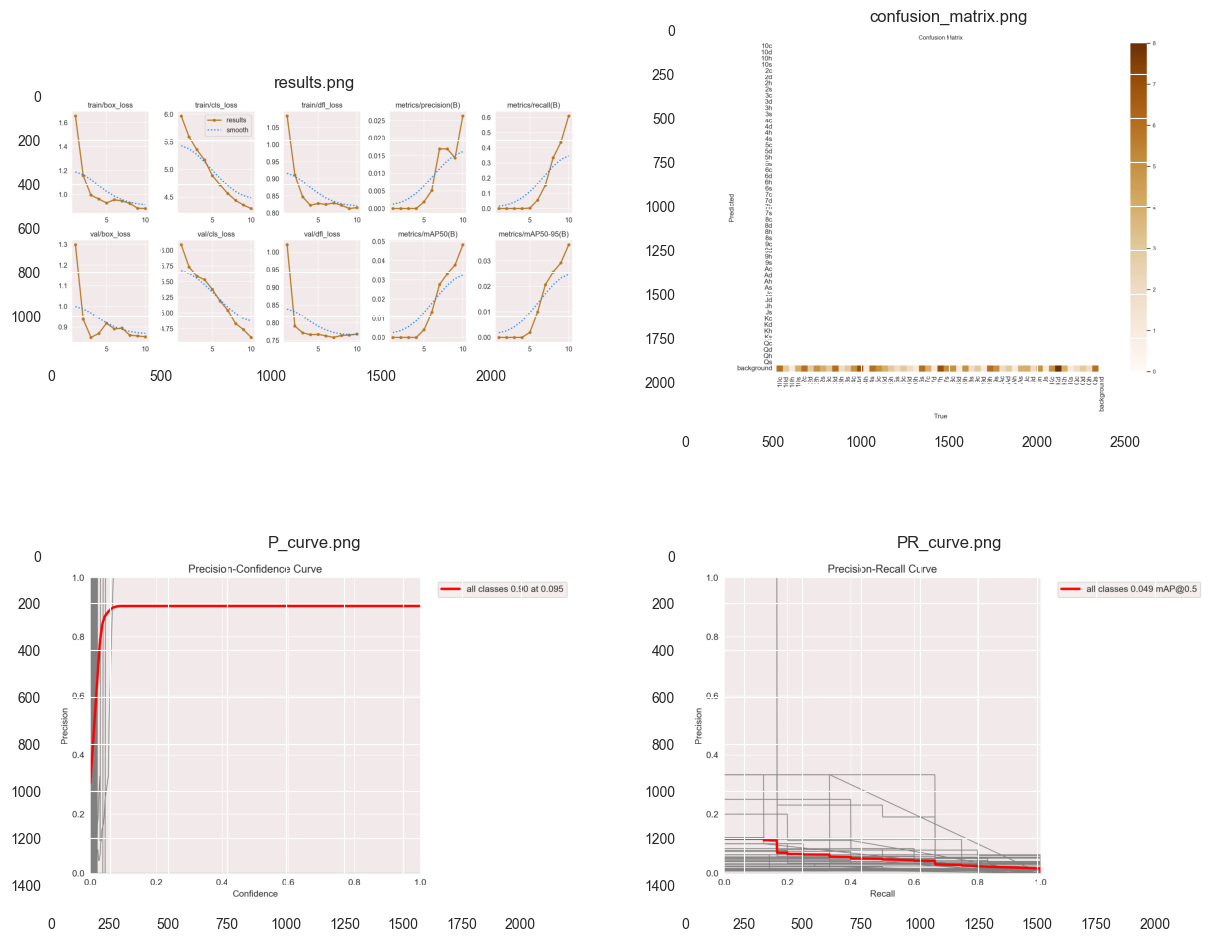

In [66]:
# List of some metrics
metrics = ['results.png','confusion_matrix.png', 'P_curve.png', 'PR_curve.png']

plt.figure(figsize=(15, 12))
i = 1

for image_name in metrics:
    image_path = os.path.join(result_path, image_name)
    image = cv2.imread(image_path)
    
    plt.subplot(2, 2, i)
    
    plt.imshow(image)
    plt.title(image_name)
    i += 1

plt.show()

In [67]:
# Read csv of result
df = pd.read_csv(os.path.join(result_path, 'results.csv'))
df.tail(5)

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
5,6,0.95656,4.7224,0.82531,0.00517,0.05609,0.01308,0.00994,0.89088,5.1908,0.76300,0.000059,0.000059,0.000059
6,7,0.94721,4.5656,0.82957,0.01700,0.15449,0.02762,0.02070,0.89515,5.0409,0.75858,0.000055,0.000055,0.000055
7,8,0.92635,4.4412,0.82317,0.01696,0.33462,0.03321,0.02565,0.86069,4.8333,0.76410,0.000048,0.000048,0.000048
8,9,0.88619,4.3579,0.81331,0.01440,0.43704,0.03779,0.02928,0.85720,4.7351,0.76508,0.000036,0.000036,0.000036
9,10,0.88357,4.2943,0.81598,0.02635,0.61000,0.04832,0.03633,0.85281,4.6110,0.76840,0.000020,0.000020,0.000020


In [68]:
# Strip columns
df.columns = df.columns.str.strip()
df.columns

Index(['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')

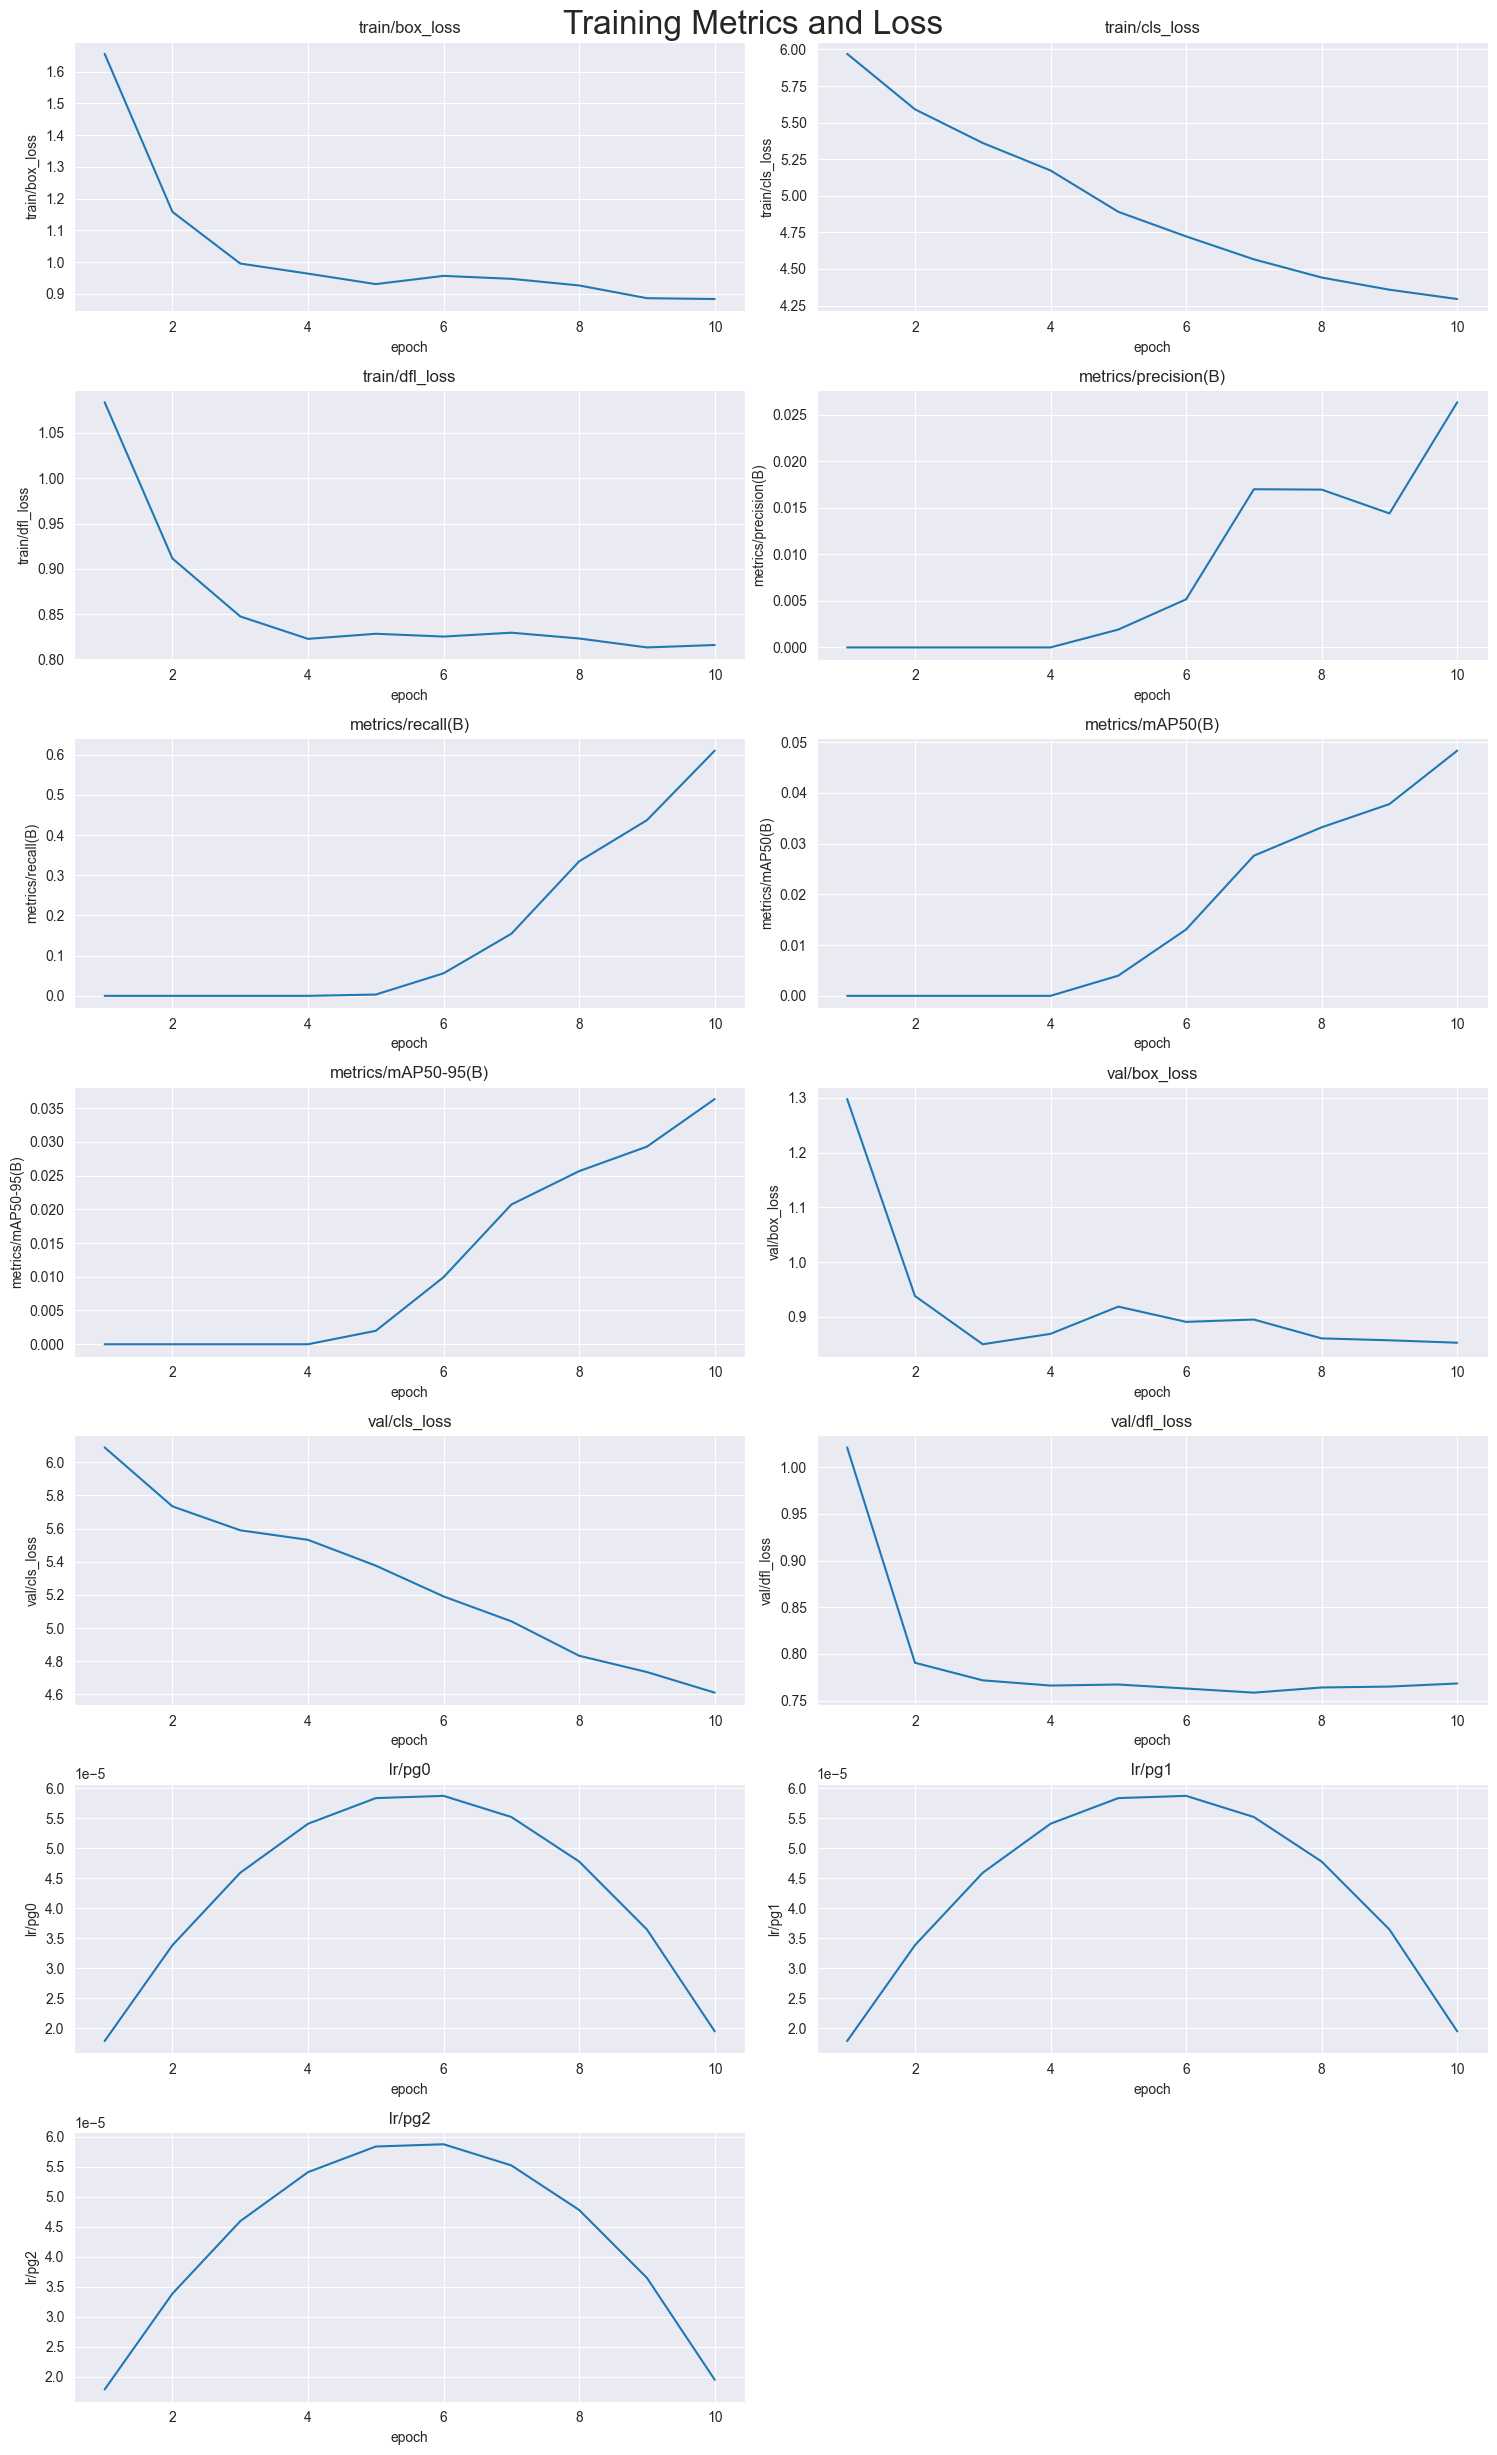

In [69]:
# Define X, y to plot
X = df.epoch
cols = df.columns[1:]

plt.figure(figsize=(15, 25))

for it in range(len(cols)) :
    plt.subplot(7, 2, it+1)
    ax = sns.lineplot(data=df, x=X, y=cols[it])
    ax.set_title(cols[it])
plt.suptitle('Training Metrics and Loss', fontsize=24)
plt.subplots_adjust(top=0.6)
plt.tight_layout()
plt.show()

In [70]:
# Load model with best weights
best_model_path = os.path.join(result_path, 'weights/best.pt')

best_model = YOLO(best_model_path)

In [71]:
# Evaluating the model
result_test = best_model.val()

Ultralytics YOLOv8.2.76  Python-3.11.9 torch-2.1.2+cpu CPU (Intel Core(TM) i5-10400 2.90GHz)
YOLOv8n summary (fused): 168 layers, 3,015,788 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\Admin\Desktop\DuckCode\Python\DetectCardTerrabet\datasets\valid\labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.15s/it]


                   all         38        189     0.0264       0.61     0.0485     0.0365
                   10c          6          6     0.0298      0.833     0.0459     0.0359
                   10d          3          3     0.0168          1     0.0247     0.0187
                   10h          1          1          0          0          0          0
                   10s          4          4     0.0165          1     0.0934     0.0773
                    2c          6          6     0.0336      0.667     0.0396     0.0322
                    2d          3          3     0.0124      0.667     0.0224     0.0161
                    2h          5          5     0.0286          1      0.037     0.0307
                    2s          4          4     0.0187        0.5     0.0156     0.0125
                    3c          3          3     0.0247      0.667      0.226      0.187
                    3d          6          6     0.0316          1     0.0418     0.0346
                    3

In [72]:
result_test

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000122E8697750>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.0

In [73]:
keys = ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']

for key in keys :
    print(colored(f'{key} : {result_test.results_dict[key]}', 'green', attrs=['bold']))

metrics/precision(B) : 0.026438774889898115
metrics/recall(B) : 0.6100045787545787
metrics/mAP50(B) : 0.04851654368491755
metrics/mAP50-95(B) : 0.0364963029759423


### Test predictions

In [79]:
from PIL import Image

# test_img = "labai1.jpg"
test_img = "./datasets/test/images/2024-08-12-22-35-03_mp4-0007_jpg.rf.eda4a8f142fed9363991917a420ede69.jpg"
img1 = Image.open(test_img)


result = best_model.predict([img1], save=True, conf=0.1, iou=0.7)


0: 640x640 (no detections), 112.9ms
Speed: 5.7ms preprocess, 112.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
